In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps
import pandas as pd
import sys
# sys.path.append("..")

Visualization of quantification noise

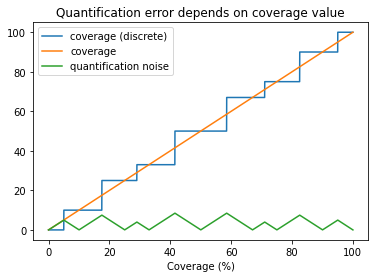

In [2]:
x = np.linspace(0,100,20001)
bins_borders = np.array([5,17.5,29,41.5,58.5,71,82.5,95,101])
bins_centers = np.array([0,10,25,33,50,67,75,90,100])
y_classes = np.digitize(x, bins_borders)
y_quant = bins_centers[y_classes[:,None]].squeeze()
error = np.abs(x-y_quant)

plt.title("Quantification error depends on coverage value")
plt.plot(x, y_quant, label="coverage (discrete)")
plt.plot(x, x, label = "coverage")
plt.plot(x, error, label = "quantification noise")
plt.xlabel("Coverage (%)")
plt.legend()

plt.show()

Calculation of quantification noise expected value, under uniform coverage distribution assumptions

In [3]:
error.mean().round(2)

3.39

Calculation of quantification noise expected value, under plots coverage distribution

In [4]:
errors_by_class = np.zeros(shape=(9,))
for i in range(9):
    errors_by_class[i] = error[y_classes==i].mean()
errors_by_class = errors_by_class.round(2)
errors_by_class_mapper = {val_quant:mean_error for val_quant,mean_error in zip(bins_centers, errors_by_class)}
# See values:
l = list(zip(bins_centers, len(bins_centers)*["->"],errors_by_class, len(bins_centers)*["%pts"]))
l

[(0, '->', 2.5, '%pts'),
 (10, '->', 3.25, '%pts'),
 (25, '->', 3.14, '%pts'),
 (33, '->', 3.53, '%pts'),
 (50, '->', 4.25, '%pts'),
 (67, '->', 3.53, '%pts'),
 (75, '->', 3.14, '%pts'),
 (90, '->', 3.25, '%pts'),
 (100, '->', 2.5, '%pts')]

Chargement du fichier de résultats

In [5]:
experiment_rel_path = "../experiments/RESULTS_3_strata/only_stratum/PROD/2021-05-31_11h40m21s/PCC_inference_all_placettes.csv"
format_percentage_to_float = lambda x: float(x.replace("%",""))
cols_to_format = ['pred_veg_b', 'pred_sol_nu', 'pred_veg_moy', 'pred_veg_h',
                  'vt_veg_b', 'vt_sol_nu', 'vt_veg_moy', 'vt_veg_h','error_veg_b', 
                  'error_veg_moy', 'error_veg_b_and_moy']
df = pd.read_csv(experiment_rel_path, converters={key:format_percentage_to_float for key in cols_to_format})
df[["pl_id","vt_veg_b","vt_veg_moy","vt_veg_h"]].head()

,pl_id,vt_veg_b,vt_veg_moy,vt_veg_h
0,Releve_Lidar_F68,0.0,100.0,0.0
1,2021_POINT_OBS60,25.0,75.0,0.0
2,POINT_OBS67,10.0,75.0,33.0
3,POINT_OBS71,25.0,75.0,90.0
4,Releve_Lidar_F69,10.0,75.0,75.0


Actual expected error of oracle by vegetation strata

In [6]:
df_errors = df.copy()
df_errors[["vt_veg_b","vt_veg_moy","vt_veg_h"]] = df_errors[["vt_veg_b","vt_veg_moy","vt_veg_h"]].replace(errors_by_class_mapper)
print(f"Actual error due to quantization: {df_errors[['vt_veg_b','vt_veg_moy','vt_veg_h']].values.mean()}")
df_errors[["vt_veg_b","vt_veg_moy","vt_veg_h"]].describe().loc["mean"]

Actual error due to quantization: 3.077384615384615


vt_veg_b      3.145538
vt_veg_moy    3.056410
vt_veg_h      3.030205
Name: mean, dtype: float64

Calculation of class accuracy

In [7]:
df_class_acc = df.copy()
for coln in ["pred_veg_b", "pred_veg_moy","pred_veg_h"]:
    df_class_acc[coln] = pd.cut(df_class_acc[coln], [-1] + bins_borders.tolist(), labels=bins_centers)

In [8]:
acc_b = (df_class_acc["pred_veg_b"] == df_class_acc["vt_veg_b"]).mean().round(2)
acc_moy = (df_class_acc["pred_veg_moy"] == df_class_acc["vt_veg_moy"]).mean().round(2)
acc_h = (df_class_acc["pred_veg_h"] == df_class_acc["vt_veg_h"]).mean().round(2)
t = [acc_b, acc_moy, acc_h]
print(t, np.mean(t).round(2))

[0.45, 0.45, 0.58] 0.49


Calculation of adapted MAE, relative to class to predict

In [49]:
df_mae2 = df.copy()
# for coln in ["vt_veg_b", "vt_veg_moy","vt_veg_h"]:
#     df_mae2[coln] = pd.cut(df_mae2[coln], [-1] + bins_borders.tolist())

In [52]:
# define mae2
bb = [0] + bins_borders.tolist()
center_to_border_dict = {center: borders for center, borders in zip(bins_centers, zip(bb[:-1], bb[1:]))}
center_to_border_dict
def compute_mae2(pred, vt):
    borders = center_to_border_dict[vt]
    if borders[0] <= pred <= borders[1]:
        return 0.0
    else:
        return min( abs(borders[0]-pred), abs(borders[1]-pred))
    
# apply to df
mae2_b = df_mae2.apply(lambda x: compute_mae2(x.pred_veg_b, x.vt_veg_b), axis=1).mean().round(2)
mae2_moy = df_mae2.apply(lambda x: compute_mae2(x.pred_veg_moy, x.vt_veg_moy), axis=1).mean().round(2)
mae2_h = df_mae2.apply(lambda x: compute_mae2(x.pred_veg_h, x.vt_veg_h), axis=1).mean().round(2)
mae2_b, mae2_moy, mae2_h

(11.59, 9.96, 3.68)

In [64]:
# get average width of class for each class
def compute_width(vt):
    borders = center_to_border_dict[vt]
    return abs(borders[0] -borders[1])  
# apply to df
width_b = df_mae2.apply(lambda x: compute_width(x.vt_veg_b), axis=1).mean().round(2)
width_moy = df_mae2.apply(lambda x: compute_width(x.vt_veg_moy), axis=1).mean().round(2)
width_h = df_mae2.apply(lambda x: compute_width(x.vt_veg_h), axis=1).mean().round(2)
width_b, width_moy, width_h

(10.75, 9.89, 9.83)